<div class="alert alert-block alert-info">
<b>Tip:</b> Install the jupyter notebook first.
</div>

# Installing Jupyter Notebook in terminal

```bash
# Navigate to the home directory
cd ~

# Install Jupyter Notebook using pip3
pip3 install jupyter


# Plot those columns with less than 1006 missing value

In [1]:
# import modulus
import pandas as pd
# import os
# script_path = 'missing_table.py'
# os.system(f'python3 {script_path}')
# !python missing_table.py
from missing_table import missing_value_df
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# This function converts the string into the type of datetime %d/%m/%Y
def convert_date_format(date_str):
    try:
        date_time_obj = datetime.strptime(date_str, '%d/%m/%Y %H:%M')
        formatted_date = date_time_obj.strftime('%m/%d/%Y')
        return formatted_date
    except ValueError:
        pass

    try:
        date_time_obj = datetime.strptime(date_str, '%d/%m/%Y')
        return date_str
    except ValueError:
        raise ValueError(f"Unsupported date format: {date_str}")

In [3]:
#  FIRST TRY:
# note: More needs to be added to this script to clean the columns as needs be
# edit: 

# edit: changed filed path
df = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# create a new column in the csv that computer from week 1 for every two weeks 
df["endtime"] = df["endtime"].apply(convert_date_format)
df["endtime"] = pd.to_datetime(df["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df['endtime'].min()
end_date = df['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df['week_number'] = ((df['endtime'] - start_date).dt.days // 14) + 1

# Filter out the day with less than 5 data points
df_grouped_size = df.groupby("week_number").size()

# Filter out groups with sizes less than 300
valid_endtimes = df_grouped_size[df_grouped_size >= 300].index

# Filter the original DataFrame to keep only rows with valid endtimes
df = df[df["week_number"].isin(valid_endtimes)]

# Set the threshold for missing value count
# edit: change cound to 1006
thresh_value = 1006

# Extract the variable names with missing value counts larger than 1006
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df.drop(columns=columns_to_drop, inplace=True)
df.dropna(inplace=True)

print(df)

       RecordNo    endtime    qweek i9_health        i11_health i12_health_1  \
0             0 2020-04-01   week 1       Yes      Very willing       Rarely   
1             1 2020-04-01   week 1       Yes      Very willing   Not at all   
2             2 2020-04-01   week 1       Yes      Very willing       Always   
3             3 2020-04-01   week 1       Yes      Very willing       Always   
4             4 2020-04-01   week 1       Yes  Somewhat willing   Not at all   
...         ...        ...      ...       ...               ...          ...   
52822     52822 2022-03-16  week 53        No  Somewhat willing   Frequently   
52823     52823 2022-03-16  week 53  Not sure      Very willing    Sometimes   
52824     52824 2022-03-16  week 53  Not sure      Very willing   Not at all   
52825     52825 2022-03-16  week 53       Yes      Very willing   Frequently   
52826     52826 2022-03-16  week 53        No      Very willing       Always   

      i12_health_2 i12_health_3 i12_hea

In [4]:
# plot states_in_proportion pre-setting

df["endtime"] = pd.to_datetime(df["endtime"])   
df = df.sort_values(by=["endtime"])

frequency_dict = {"Always": 1, "Frequently": 1, "Sometimes": 0, "Rarely": 0, "Not at all": 0}
df["i12_health_1"] = df["i12_health_1"].map(frequency_dict)

# Assuming df is your original dataframe
df_count = df.groupby(["week_number", "endtime", "state", "i12_health_1"]).size().unstack(fill_value=0).reset_index()
df_count.columns = ["week_number", "endtime", "state", 
                    "wearing mask = 'No'", "wearing mask = 'Yes'"]
# plot figures in states. proportion
df_count["prop_no"] = df_count["wearing mask = 'No'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])
df_count["prop_yes"] = df_count["wearing mask = 'Yes'"] / (df_count["wearing mask = 'No'"] + df_count["wearing mask = 'Yes'"])
# the regulation dates
states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df_count[df_count["state"]== "Australian Capital Territory"])

      week_number    endtime                         state  \
0               1 2020-04-01  Australian Capital Territory   
8               1 2020-04-02  Australian Capital Territory   
17              1 2020-04-07  Australian Capital Territory   
25              1 2020-04-08  Australian Capital Territory   
36              2 2020-04-15  Australian Capital Territory   
...           ...        ...                           ...   
2780           51 2022-03-08  Australian Capital Territory   
2787           51 2022-03-09  Australian Capital Territory   
2795           51 2022-03-10  Australian Capital Territory   
2803           51 2022-03-11  Australian Capital Territory   
2810           51 2022-03-12  Australian Capital Territory   

      wearing mask = 'No'  wearing mask = 'Yes'  prop_no  prop_yes  
0                       8                     2    0.800     0.200  
8                       6                     2    0.750     0.250  
17                      5                     0 

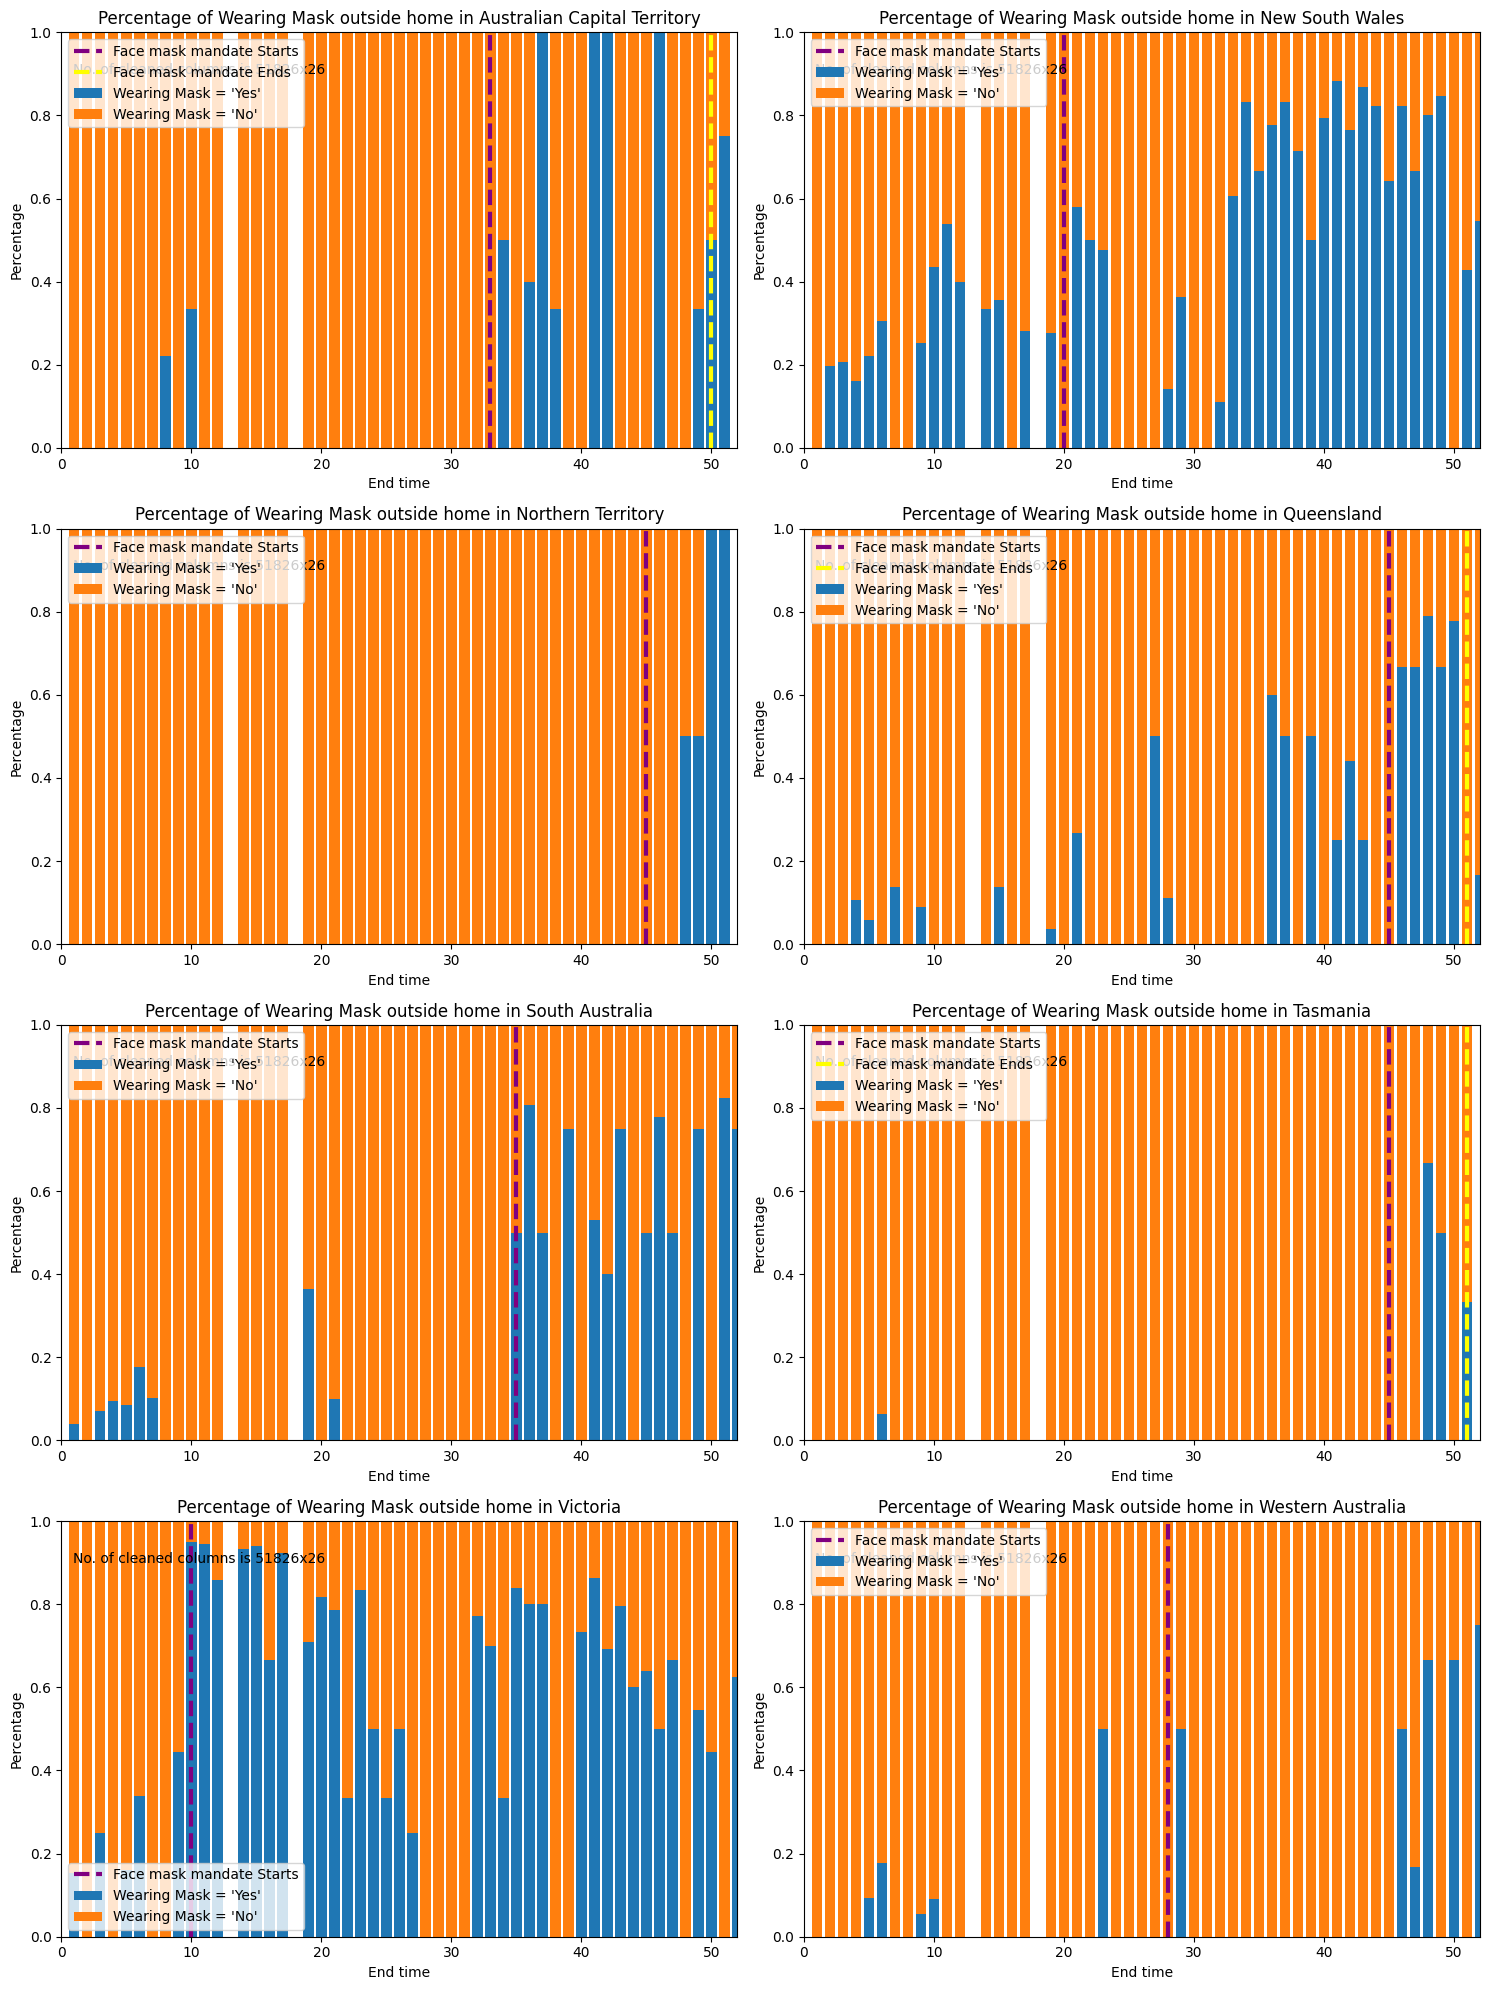

In [5]:
# Plotting figures for each state in two columns
states = df_count["state"].unique()
num_states = len(states)
cols = len(df.columns)
rows = len(df)

fig, axes = plt.subplots(num_states // 2, 2, figsize=(15, 5 * (num_states // 2 + num_states % 2)))

for idx, state in enumerate(states):
    ax = axes[idx // 2, idx % 2] if num_states > 1 else axes
    
    state_df = df_count[df_count["state"] == state]
    
    ax.bar(state_df["week_number"], state_df["prop_yes"], label="Wearing Mask = 'Yes'")
    ax.bar(state_df["week_number"], state_df["prop_no"], bottom=state_df["prop_yes"], label="Wearing Mask = 'No'")
    
    # Add vertical lines for start and end times
    start_time, end_time = states_data[state]
        
    if start_time:
        start_time = pd.to_datetime(start_time, format='%d/%m/%Y')
        ax.axvline(x=((start_time - start_date).days // 14) + 1, color='purple', linestyle='--', linewidth = 3, label='Face mask mandate Starts')
    if end_time and (state == "Australian Capital Territory" or state == "Queensland" or state == "Tasmania"):
        end_time = pd.to_datetime(end_time, format='%d/%m/%Y')
        ax.axvline(x=((end_time - start_date).days // 14) + 1, color='yellow', linestyle='--', linewidth = 3, label='Face mask mandate Ends')
        
    ax.set_title(f"Percentage of Wearing Mask outside home in {state}")
    ax.set_xlabel("End time")
    ax.set_ylabel("Percentage")
    ax.set_xlim(0,52)
    ax.set_ylim(0, 1)  # Fixing y-axis at 1
    ax.text(0.9, 0.9, f"No. of cleaned columns is {rows}x{cols}")
    ax.legend()

plt.tight_layout()

plt.savefig("../figures/states_in_proportion_threshold1006.png")
plt.show()

In [6]:
# ANOTHER TRY: threshold = 10029
# note: More needs to be added to this script to clean the columns as needs be

# edit: changed filed path
df2 = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# create a new column in the csv that computer from week 1 for every two weeks 
df2["endtime"] = df2["endtime"].apply(convert_date_format)
df2["endtime"] = pd.to_datetime(df2["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df2['endtime'].min()
end_date = df2['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df2['week_number'] = ((df2['endtime'] - start_date).dt.days // 14) + 1

# Filter out the day with less than 300 data points
df2_grouped_size = df2.groupby("week_number").size()

# Filter out groups with sizes less than 300
valid_endtimes = df2_grouped_size[df2_grouped_size >= 300].index

# Filter the original DataFrame to keep only rows with valid endtimes
df2 = df2[df2["week_number"].isin(valid_endtimes)]

# print(df2_grouped_size)
# Set the threshold for missing value count
# edit: change cound to 10029
thresh_value = 10029

# Extract the variable names with missing value counts larger than 10029
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df2.drop(columns=columns_to_drop, inplace=True)
df2.dropna(inplace=True)

states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df2)

       RecordNo    endtime    qweek  i2_health i9_health  \
9023       9023 2020-06-24  week 10        0.0  Not sure   
9024       9024 2020-06-24  week 10        2.0        No   
9025       9025 2020-06-24  week 10        6.0       Yes   
9026       9026 2020-06-24  week 10       20.0       Yes   
9027       9027 2020-06-24  week 10        0.0       Yes   
...         ...        ...      ...        ...       ...   
51826     51826 2022-02-26  week 52        6.0        No   
51827     51827 2022-02-26  week 52        4.0       Yes   
51828     51828 2022-03-01  week 52        3.0       Yes   
51829     51829 2022-03-01  week 52       10.0       Yes   
51830     51830 2022-03-01  week 52      100.0        No   

                          i11_health i12_health_1 i12_health_2 i12_health_3  \
9023                        Not sure    Sometimes       Rarely    Sometimes   
9024                    Very willing   Frequently    Sometimes    Sometimes   
9025                    Very willing   Not

In [7]:
# plot states_in_proportion pre-setting

df2["endtime"] = pd.to_datetime(df2["endtime"])   
df2 = df2.sort_values(by=["endtime"])

frequency_dict = {"Always": 1, "Frequently": 1, "Sometimes": 0, "Rarely": 0, "Not at all": 0}
df2["i12_health_1"] = df2["i12_health_1"].map(frequency_dict)

# Assuming df2 is original dataframe
df2_count = df2.groupby(["week_number", "endtime", "state", "i12_health_1"]).size().unstack(fill_value=0).reset_index()
df2_count.columns = ["week_number", "endtime", "state", 
                    "wearing mask = 'No'", "wearing mask = 'Yes'"]
# plot figures in states. proportion
df2_count["prop_no"] = df2_count["wearing mask = 'No'"] / (df2_count["wearing mask = 'No'"] + df2_count["wearing mask = 'Yes'"])
df2_count["prop_yes"] = df2_count["wearing mask = 'Yes'"] / (df2_count["wearing mask = 'No'"] + df2_count["wearing mask = 'Yes'"])

print(df2_count[df2_count["state"]== "Australian Capital Territory"])

      week_number    endtime                         state  \
0               7 2020-06-24  Australian Capital Territory   
8               7 2020-06-25  Australian Capital Territory   
16              7 2020-06-26  Australian Capital Territory   
30              8 2020-07-08  Australian Capital Territory   
37              8 2020-07-09  Australian Capital Territory   
...           ...        ...                           ...   
2398           50 2022-02-22  Australian Capital Territory   
2405           50 2022-02-23  Australian Capital Territory   
2412           50 2022-02-24  Australian Capital Territory   
2420           50 2022-02-25  Australian Capital Territory   
2440           50 2022-03-01  Australian Capital Territory   

      wearing mask = 'No'  wearing mask = 'Yes'   prop_no  prop_yes  
0                       3                     1  0.750000  0.250000  
8                       7                     2  0.777778  0.222222  
16                      5                    

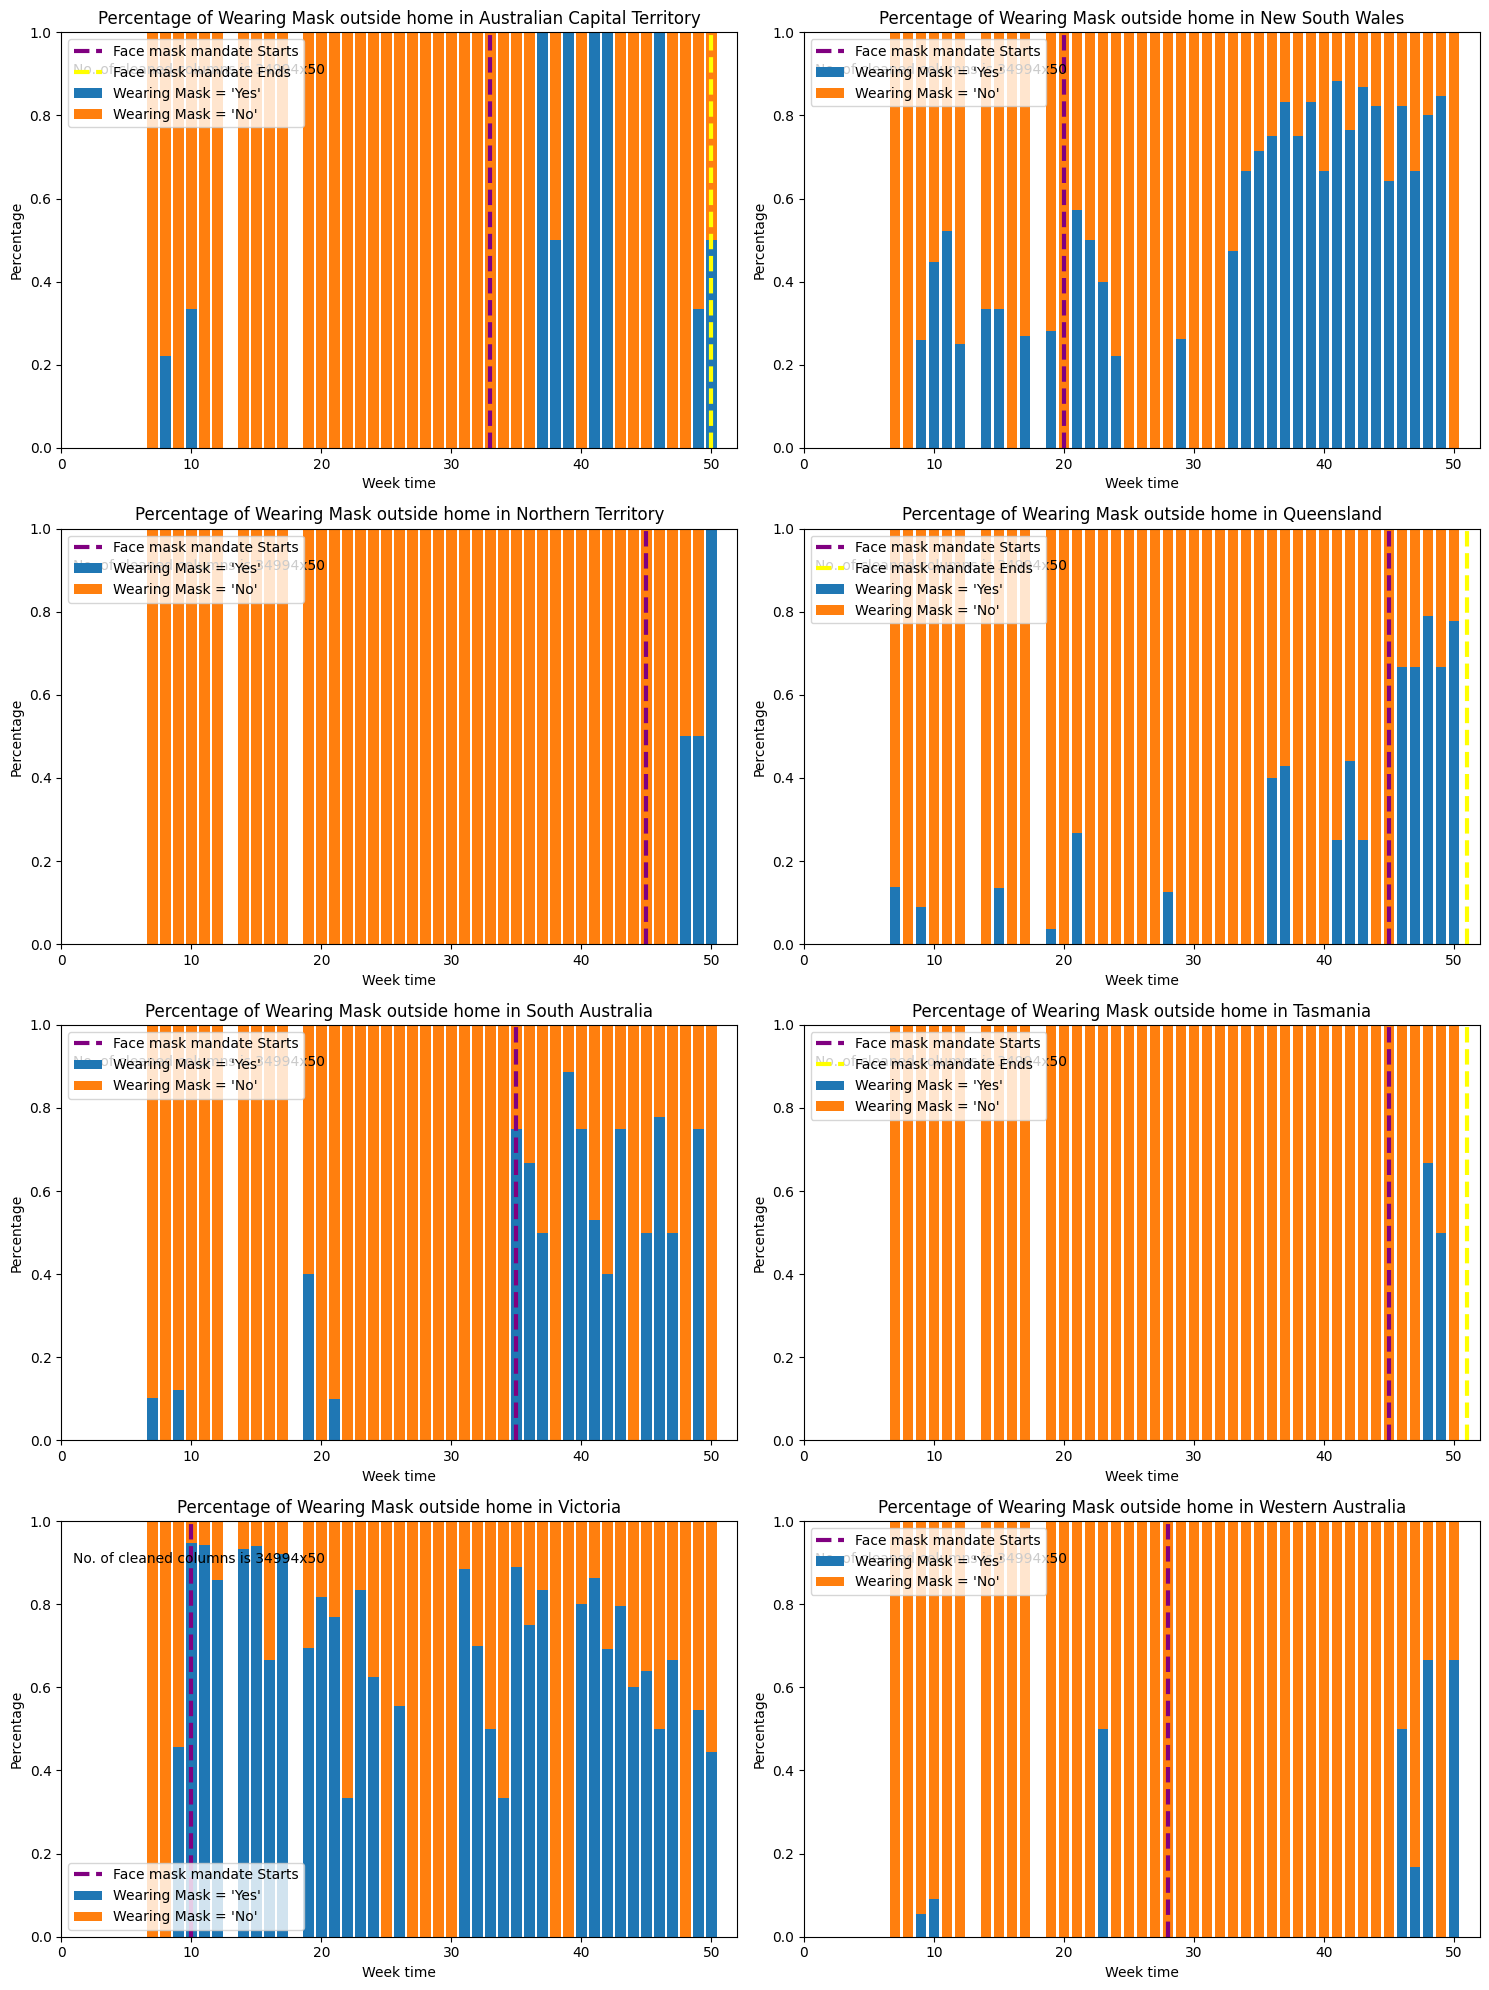

In [8]:
# Plotting figures for each state in two columns
states = df_count["state"].unique()
num_states = len(states)
cols = len(df2.columns)
rows = len(df2)

fig, axes = plt.subplots(num_states // 2, 2, figsize=(15, 5 * (num_states // 2 + num_states % 2)))

for idx, state in enumerate(states):
    ax = axes[idx // 2, idx % 2] if num_states > 1 else axes
    
    state_df2 = df2_count[df2_count["state"] == state]
    
    ax.bar(state_df2["week_number"], state_df2["prop_yes"], label="Wearing Mask = 'Yes'")
    ax.bar(state_df2["week_number"], state_df2["prop_no"], bottom=state_df2["prop_yes"], label="Wearing Mask = 'No'")
    
    # Add vertical lines for start and end times
    start_time, end_time = states_data[state]
    if start_time:
        start_time = pd.to_datetime(start_time, format='%d/%m/%Y')
        ax.axvline(x=((start_time - start_date).days // 14) + 1, color='purple', linestyle='--', linewidth = 3, label='Face mask mandate Starts')
    if end_time and (state == "Australian Capital Territory" or state == "Queensland" or state == "Tasmania"):
        end_time = pd.to_datetime(end_time, format='%d/%m/%Y')
        ax.axvline(x=((end_time - start_date).days // 14) + 1, color='yellow', linestyle='--', linewidth = 3, label='Face mask mandate Ends')
        
    ax.set_title(f"Percentage of Wearing Mask outside home in {state}")
    ax.set_xlabel("Week time")
    ax.set_ylabel("Percentage")
    ax.set_xlim(0, 52)
    ax.set_ylim(0, 1)  # Fixing y-axis at 1
    ax.text(0.9, 0.9, f"No. of cleaned columns is {rows}x{cols}")
    ax.legend()

plt.tight_layout()

plt.savefig("../figures/states_in_proportion_threshold10029.png")
plt.show()

In [9]:
# Save the cleaned DataFrame to a new CSV file
# edit: fixed file path/save location
# df.to_csv("../data/cleaned_data.csv", index=False)

In [10]:
# Observe the gender & state to see the proportion of the survey through the time
df3 = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# Filter out the day with less than 5 data points
df3_grouped_size = df3.groupby("endtime").size()

# Filter out groups with sizes less than 5
valid_endtimes = df3_grouped_size[df3_grouped_size >= 0].index

# Filter the original DataFrame to keep only rows with valid endtimes
df3 = df3[df3["endtime"].isin(valid_endtimes)]

# create a new column in the csv that computer from week 1 for every two weeks 
df3["endtime"] = df3["endtime"].apply(convert_date_format)
df3["endtime"] = pd.to_datetime(df3["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df3['endtime'].min()
end_date = df3['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df3['week_number'] = ((df3['endtime'] - start_date).dt.days // 14) + 1

# Set the threshold for missing value count
# edit: change cound to 1006
thresh_value = 1006

# Extract the variable names with missing value counts larger than 1006
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df3.drop(columns=columns_to_drop, inplace=True)
df3.dropna(inplace=True)

states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df3)

       RecordNo    endtime    qweek i9_health        i11_health i12_health_1  \
0             0 2020-04-01   week 1       Yes      Very willing       Rarely   
1             1 2020-04-01   week 1       Yes      Very willing   Not at all   
2             2 2020-04-01   week 1       Yes      Very willing       Always   
3             3 2020-04-01   week 1       Yes      Very willing       Always   
4             4 2020-04-01   week 1       Yes  Somewhat willing   Not at all   
...         ...        ...      ...       ...               ...          ...   
52822     52822 2022-03-16  week 53        No  Somewhat willing   Frequently   
52823     52823 2022-03-16  week 53  Not sure      Very willing    Sometimes   
52824     52824 2022-03-16  week 53  Not sure      Very willing   Not at all   
52825     52825 2022-03-16  week 53       Yes      Very willing   Frequently   
52826     52826 2022-03-16  week 53        No      Very willing       Always   

      i12_health_2 i12_health_3 i12_hea

     week_number    endtime  Male_no.  Female_no.      Male    Female
0              1 2020-04-01       305         270  0.530435  0.469565
1              1 2020-04-02       142         255  0.357683  0.642317
2              1 2020-04-03         1           0  1.000000  0.000000
3              1 2020-04-07       127         114  0.526971  0.473029
4              1 2020-04-08       380         380  0.500000  0.500000
..           ...        ...       ...         ...       ...       ...
471           51 2022-03-12        12          26  0.315789  0.684211
472           51 2022-03-13         2          12  0.142857  0.857143
473           51 2022-03-14         1           3  0.250000  0.750000
474           51 2022-03-15         0           2  0.000000  1.000000
475           52 2022-03-16        15          18  0.454545  0.545455

[476 rows x 6 columns]


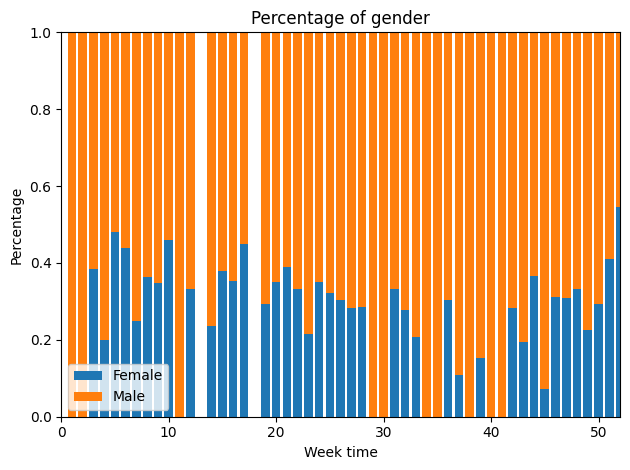

In [11]:
# plot gender
df3["endtime"] = pd.to_datetime(df3["endtime"])   
df3 = df3.sort_values(by=["endtime"])

# Assuming df3 is original dataframe
df3_count = df3.groupby(["week_number", "endtime", "gender"]).size().unstack(fill_value=0).reset_index()
df3_count.columns = ["week_number", "endtime", 
                    "Male_no.", "Female_no."]

# plot figures in states. proportion
df3_count["Male"] = df3_count["Male_no."] / (df3_count["Male_no."] + df3_count["Female_no."])
df3_count["Female"] = df3_count["Female_no."] / (df3_count["Male_no."] + df3_count["Female_no."])

print(df3_count)

plt.bar(df3_count["week_number"], df3_count["Female"], label="Female")
plt.bar(df3_count["week_number"], df3_count["Male"], bottom=df3_count["Female"], label="Male")
plt.title("Percentage of gender")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/gender_in_proportion_threshold1006.png")
plt.show()

     week_number    endtime  Australian Capital Territory  New South Wales  \
475           52 2022-03-16                             0               11   

     Northern Territory  Queensland  South Australia  Tasmania  Victoria  \
475                   0           6                4         0         8   

     Western Australia  ACT       NSW   NT       QLD        SA  TAS       VIC  \
475                  4  0.0  0.333333  0.0  0.181818  0.121212  0.0  0.242424   

           WA  
475  0.121212  


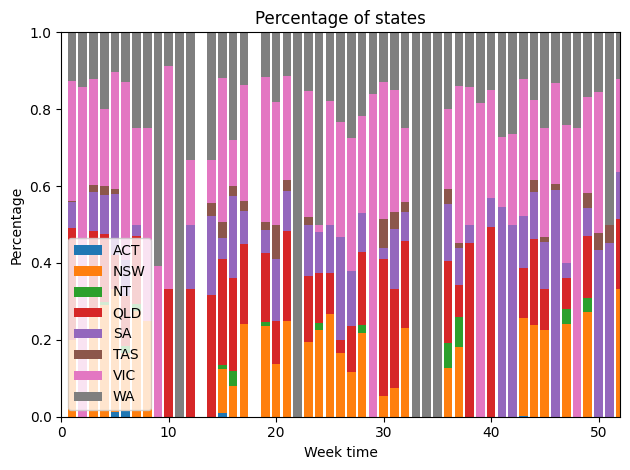

In [12]:
# plot state
df3["endtime"] = pd.to_datetime(df3["endtime"])   
df3 = df3.sort_values(by=["endtime"])

# Assuming df3 is original dataframe
df3_count = df3.groupby(["week_number", "endtime", "state"]).size().unstack(fill_value=0).reset_index()
df3_count.columns = ["week_number", "endtime", 
                    "Australian Capital Territory",
                     "New South Wales",
                     "Northern Territory",
                     "Queensland",
                     "South Australia",
                     "Tasmania",
                     "Victoria",
                     "Western Australia"]

# plot figures in states. proportion
total = (df3_count["Australian Capital Territory"]+df3_count["New South Wales"]+df3_count["Northern Territory"]+df3_count["Queensland"]+df3_count["South Australia"]+df3_count["Tasmania"]+df3_count["Victoria"]+df3_count["Western Australia"])
df3_count["ACT"] = df3_count["Australian Capital Territory"] / total
df3_count["NSW"] = df3_count["New South Wales"] / total
df3_count["NT"] = df3_count["Northern Territory"] / total
df3_count["QLD"] = df3_count["Queensland"] / total
df3_count["SA"] = df3_count["South Australia"] / total
df3_count["TAS"] = df3_count["Tasmania"] / total
df3_count["VIC"] = df3_count["Victoria"] / total
df3_count["WA"] = df3_count["Western Australia"] / total

print(df3_count[df3_count["week_number"]==52])

states = ["ACT", "NSW", "NT", "QLD", "SA", "TAS", "VIC", "WA"]

for state in states:
    plt.bar(df3_count["week_number"], df3_count[state], label=state, bottom=df3_count[states[0:states.index(state)]].sum(axis=1))

plt.title("Percentage of states")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/state_in_proportion_threshold1006.png")
plt.show()

In [13]:
# Observe the gender & state to see the proportion of the survey through the time
df4 = pd.read_csv("../raw_data/australia.csv",
                 na_values=[" ", "__NA__", "NAN"], keep_default_na = True, low_memory=False)

# Filter out the day with less than 5 data points
df4_grouped_size = df4.groupby("endtime").size()

# Filter out groups with sizes less than 5
valid_endtimes = df4_grouped_size[df4_grouped_size >= 0].index

# Filter the original DataFrame to keep only rows with valid endtimes
df4 = df4[df4["endtime"].isin(valid_endtimes)]

# create a new column in the csv that computer from week 1 for every two weeks 
df4["endtime"] = df4["endtime"].apply(convert_date_format)
df4["endtime"] = pd.to_datetime(df4["endtime"])

# Find the start date (minimum date) and end date (maximum date)
start_date = df4['endtime'].min()
end_date = df4['endtime'].max()

# Create a new column 'week_number' and assign week numbers
df4['week_number'] = ((df4['endtime'] - start_date).dt.days // 14) + 1

# Set the threshold for missing value count
# edit: change cound to 10029
thresh_value = 10029

# Extract the variable names with missing value counts larger than 10029
columns_to_drop = missing_value_df.loc[missing_value_df['Missing Value Count']
                                       > thresh_value, 'Variable Name'].tolist()

df4.drop(columns=columns_to_drop, inplace=True)
df4.dropna(inplace=True)

states_data = {
    "Australian Capital Territory": ["28/6/2021", "25/2/2022"],
    "New South Wales": ["4/1/2021", "20/9/2022"],
    "Northern Territory": ["19/12/2021", "5/3/2022"],
    "Queensland": ["18/12/2021", "7/3/2022"],
    "South Australia": ["27/7/2021", "20/9/2022"],
    "Tasmania": ["21/12/2021", "5/3/2022"],
    "Victoria": ["16/8/2020", "22/9/2022"], 
    "Western Australia": ["23/4/2021", "9/9/2022"]
}

print(df4)

       RecordNo    endtime    qweek  i2_health i9_health  \
9023       9023 2020-06-24  week 10        0.0  Not sure   
9024       9024 2020-06-24  week 10        2.0        No   
9025       9025 2020-06-24  week 10        6.0       Yes   
9026       9026 2020-06-24  week 10       20.0       Yes   
9027       9027 2020-06-24  week 10        0.0       Yes   
...         ...        ...      ...        ...       ...   
51826     51826 2022-02-26  week 52        6.0        No   
51827     51827 2022-02-26  week 52        4.0       Yes   
51828     51828 2022-03-01  week 52        3.0       Yes   
51829     51829 2022-03-01  week 52       10.0       Yes   
51830     51830 2022-03-01  week 52      100.0        No   

                          i11_health i12_health_1 i12_health_2 i12_health_3  \
9023                        Not sure    Sometimes       Rarely    Sometimes   
9024                    Very willing   Frequently    Sometimes    Sometimes   
9025                    Very willing   Not

     week_number    endtime  Male_no.  Female_no.      Male    Female
0              7 2020-06-24       106         109  0.493023  0.506977
1              7 2020-06-25       192         175  0.523161  0.476839
2              7 2020-06-26       194         186  0.510526  0.489474
3              7 2020-06-27         4          16  0.200000  0.800000
4              7 2020-06-28         3           1  0.750000  0.250000
..           ...        ...       ...         ...       ...       ...
420           50 2022-02-24        74          66  0.528571  0.471429
421           50 2022-02-25        55          67  0.450820  0.549180
422           50 2022-02-26        20          29  0.408163  0.591837
423           50 2022-02-27         1          22  0.043478  0.956522
424           50 2022-03-01         0           4  0.000000  1.000000

[425 rows x 6 columns]


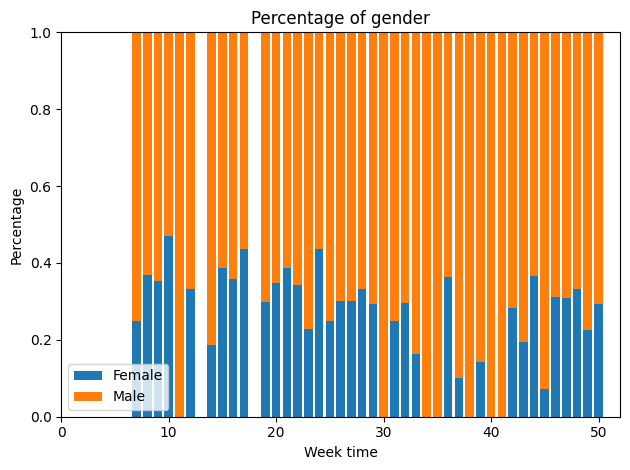

In [14]:
# plot gender
df4["endtime"] = pd.to_datetime(df4["endtime"])   
df4 = df4.sort_values(by=["endtime"])

# Assuming df4 is original dataframe
df4_count = df4.groupby(["week_number", "endtime", "gender"]).size().unstack(fill_value=0).reset_index()
df4_count.columns = ["week_number", "endtime", 
                    "Male_no.", "Female_no."]

# plot figures in states. proportion
df4_count["Male"] = df4_count["Male_no."] / (df4_count["Male_no."] + df4_count["Female_no."])
df4_count["Female"] = df4_count["Female_no."] / (df4_count["Male_no."] + df4_count["Female_no."])

print(df4_count)

plt.bar(df4_count["week_number"], df4_count["Female"], label="Female")
plt.bar(df4_count["week_number"], df4_count["Male"], bottom=df4_count["Female"], label="Male")
plt.title(f"Percentage of gender")
plt.title("Percentage of gender")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/gender_in_proportion_threshold10029.png")
plt.show()

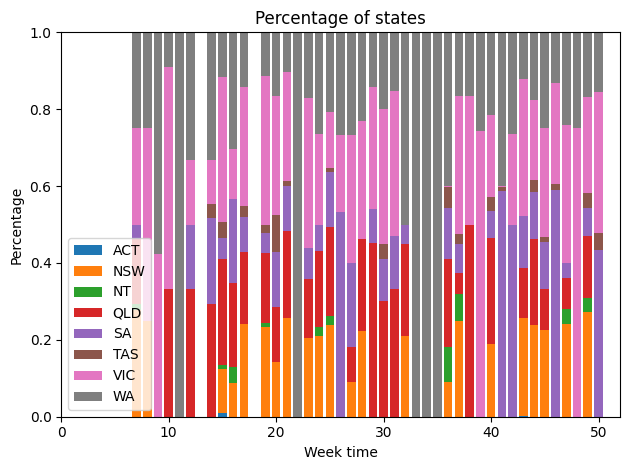

In [15]:
# plot state
df4["endtime"] = pd.to_datetime(df4["endtime"])   
df4 = df4.sort_values(by=["endtime"])

# Assuming df4 is original dataframe
df4_count = df4.groupby(["week_number", "endtime", "state"]).size().unstack(fill_value=0).reset_index()
df4_count.columns = ["week_number", "endtime", 
                    "Australian Capital Territory",
                     "New South Wales",
                     "Northern Territory",
                     "Queensland",
                     "South Australia",
                     "Tasmania",
                     "Victoria",
                     "Western Australia"]

# plot figures in states. proportion
total = (df4_count["Australian Capital Territory"]+df4_count["New South Wales"]+df4_count["Northern Territory"]+df4_count["Queensland"]+df4_count["South Australia"]+df4_count["Tasmania"]+df4_count["Victoria"]+df4_count["Western Australia"])
df4_count["ACT"] = df4_count["Australian Capital Territory"] / total
df4_count["NSW"] = df4_count["New South Wales"] / total
df4_count["NT"] = df4_count["Northern Territory"] / total
df4_count["QLD"] = df4_count["Queensland"] / total
df4_count["SA"] = df4_count["South Australia"] / total
df4_count["TAS"] = df4_count["Tasmania"] / total
df4_count["VIC"] = df4_count["Victoria"] / total
df4_count["WA"] = df4_count["Western Australia"] / total

states = ["ACT", "NSW", "NT", "QLD", "SA", "TAS", "VIC", "WA"]

for state in states:
    plt.bar(df4_count["week_number"], df4_count[state], label=state, bottom=df4_count[states[0:states.index(state)]].sum(axis=1))

plt.title("Percentage of states")
plt.xlabel("Week time")
plt.ylabel("Percentage")
plt.xlim(0, 52)
plt.ylim(0, 1)  # Fixing y-axis at 1
plt.legend()
plt.tight_layout()
plt.savefig("../figures/state_in_proportion_threshold10029.png")
plt.show()